# Modern architecture patterns for CIFAR-10 classification

CIFAR-10 is a famous collection of small color images, each 32 x 32 pixels.  There are 6,000 images in each of 10 classes.

https://www.cs.toronto.edu/~kriz/cifar.html

In this assignment you will play with a CNN model to learn about newer CNN architecture patterns.

## Instructions

In the code below, a baseline CNN classifier is created and tested.

In most of the problems, your job is to copy the baseline classifier, make changes to it, and see how it performs.

In the final problem, your job is to create a classifier to get the highest test accuracy you can.

Read the code, and look for problem prompts.  Provide commentary in all problems.

v1.2

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, Input, Model, Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

In [2]:
# allow output to span multiple output lines in the console
pd.set_option('display.max_columns', 600)
pd.options.display.width = 120
pd.options.display.max_colwidth = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = 5,3

In [4]:
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """

    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

In [5]:
np.random.seed(0)

### Read the data

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
num_classes = np.unique(y_train).size

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(num_classes)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
10


In [8]:
print(X_train.min(), X_train.max())
print(np.unique(y_train))

0 255
[0 1 2 3 4 5 6 7 8 9]


#### We'll use a smaller version of the data to speed up the training process.

This dataset is a little larger than used in an earlier assignment.

In [9]:
idx = np.random.choice(X_train.shape[0], 35000, replace=False)
X_train = X_train[idx]
y_train = y_train[idx]

idx = np.random.choice(X_test.shape[0], 8000, replace=False)
X_test = X_test[idx]
y_test = y_test[idx]

### Preprocess the data

In [10]:
# from integers in [0,255] to float in [0,1]
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype('float32') / 255

# store the labels in 1D arrays, not 2D
y_train = np.squeeze(y_train)  # this could also be done using reshape
y_test = np.squeeze(y_test)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35000, 32, 32, 3)
(35000,)
(8000, 32, 32, 3)
(8000,)


<hr style="border:1px solid gray">

### Baseline CNN model

<hr style="border:1px solid gray">

In [12]:
def get_model(input_shape, output_size, *, dropout=0.5, act_fun='elu', padding='same', conv_layers=[32, 64, 128], dense_layers=[64], conv_size=3, pool_size=2):
    
    inputs = Input(input_shape)
    x = inputs
    
    for num_filters in conv_layers:
        x = layers.Conv2D(num_filters, conv_size, activation=act_fun, padding=padding)(x)
        x = layers.Conv2D(num_filters, conv_size, activation=act_fun, padding=padding)(x)
        x = layers.MaxPooling2D(pool_size)(x)

    x = layers.Flatten()(x)
    
    for dense_size in dense_layers:
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(dense_size, activation=act_fun)(x)

    x = layers.Dropout(dropout)(x)
    x = layers.Dense(output_size, activation='softmax')(x)
    
    return Model(inputs, x)

In [13]:
K.clear_session()
model = get_model(X_train.shape[1:], num_classes)

2024-11-04 08:06:35.225712: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-11-04 08:06:35.225741: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-11-04 08:06:35.225748: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-11-04 08:06:35.225766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-04 08:06:35.225775: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 418,794 (1.60 MB)

 Trainable params: 418,794 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# note the 'restore_best_weights' parameter
early_stopping = EarlyStopping(patience=8, restore_best_weights=True, verbose=1)

In [16]:
optimizer = tf.keras.optimizers.Nadam()
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2,
                   callbacks=[early_stopping])

Epoch 1/100


2024-11-04 08:06:36.062365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.3014 - loss: 1.9102 - val_accuracy: 0.5670 - val_loss: 1.2506
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.5348 - loss: 1.3200 - val_accuracy: 0.6403 - val_loss: 1.0246
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.6130 - loss: 1.0998 - val_accuracy: 0.6714 - val_loss: 0.9429
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.6486 - loss: 1.0110 - val_accuracy: 0.6904 - val_loss: 0.8964
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.6701 - loss: 0.9588 - val_accuracy: 0.6974 - val_loss: 0.8621
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.6857 - loss: 0.8943 - val_accuracy: 0.7014 - val_loss: 0.8577
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.7026 - loss: 0.8576 - val_accuracy: 0.7126 - val_loss: 0.8409
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.7174 - loss: 0.8189 - val_

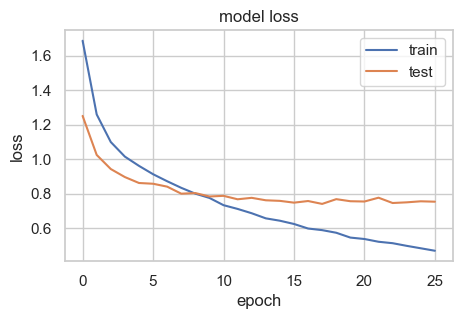

In [18]:
plot_metric(history)

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7393 - loss: 0.7643


In [20]:
print(f'test accuracy: {test_accuracy:.3g}')

test accuracy: 0.747


#### Commentary

This is a typical, classical CNN model, with several blocks of convolution followed by pooling, a single dense layer, and then the final output layer.

With early stopping, the model trained in 24 epochs, but the plot shows that little reduction in validation loss happened after about 12 epochs.

A test accuracy of 0.755 was achieved.

<hr style="border:1px solid gray">

### Problem 1.  Residual connections

Copy the cells below the 'Baseline CNN model' header, including the commentary cell, and paste it below this header.
Then add residual connections to the model.  I suggest you add the residual connection around the code inside the "conv_layers loop".  However, if you have a better idea of where to apply residual connections, go ahead and do that.

Make no changes to the code except to add the residual connection code.  We want to isolate the impact of using residual connections.

Of course, you should replace the commentary text with your commentary about what you learned about residual connections when applied to this problem.  For example, did training take longer?  Did the model size change?  How did the test accuracy change?  You will probably want to include all of these points, but do not limit your commentary to these points.

<hr style="border:1px solid gray">

<hr style="border:1px solid gray">

### Problem 2. Depthwise separable convolution

Copy the cells below the 'Baseline CNN model' header, including the commentary cell, and paste it below this head.
Then replace the convolutional layers with depthwise separable convolution layers.  Use your judgement in making the change.
Make no other changes to the code.  Be sure to use the baseline code as your starting point, not the residual connection code.

There is some possible confusion in the names of convolutional layers in the Keras API.  Please follow our text and lectures; use 'SeparableConv2d'.

Again, replace the commentary with your commentary.  Your commentary is very important.

<hr style="border:1px solid gray">

<hr style="border:1px solid gray">

### Problem 3. Batch normalization

Copy the cells below the 'Baseline CNN model' header, including the commentary cell, and paste it below this head.
Then add batch normalization to your model.  Follow the best practice for batch normalization that is described in Cholllet's
text and was mentioned in the Modern Architectural Patterns lecture.

You can apply batch normalization after the second convolutional layer of the convolutional block, but use your judgement and information from lectures and our texts.  As always, be sure to use the baseline code as your starting point, not the code of the previous problem.

Replace the commentary with your own commentary.

<hr style="border:1px solid gray">

<hr style="border:1px solid gray">

### Problem 4. Strided convolution

Copy the cells below the 'Baseline CNN model' header, including the commentary cell, and paste it below this head.
Then use strided convolution instead of pooling.  If you are not sure where to use strided convolution,
use our texts, lecture information, and your best judgement.

Replace the commentary with your own commentary.

<hr style="border:1px solid gray">

<hr style="border:1px solid gray">

### Problem 5. Data augmentation

Copy the cells below the 'Baseline CNN model' header, including the commentary cell, and paste it below this head.
Then use data augmentation, following ideas in the Chollet text and in lecture slides.
You can use the specific augmentations that Chollet uses, or you can try variations, additions, and alternatives.

Replace the commentary with your own commentary.

Note: in newer versions of Keras you can write code like `layers.RandomFlip`, but in older versions, you need to write `layers.experimental.preprocessing.RandomFlip()`.

Note: your augmentation should, for the sake for Problem 7 ahead, take the form of a small model named `data_augmentation`

```python
data_augmentation = Sequential([
    # Your augmentation layers here
])
```

<hr style="border:1px solid gray">

<hr style="border:1px solid gray">

### Problem 6. Reduce learning rate on plateau

Keras has a callback named ReduceLROnPlateau, which reduces the learning rate when the validation loss stops improving.  It can often help significantly in training.

Copy the cells below the 'Baseline CNN model' header, including the commentary cell, and paste it below this head.
Then use the ReduceLROnPlateau callback as a second callback when calling model.fit().
I set the patience parameter to 4, the min_lr parameter to 0.000001, and the verbose parameter to 1, but you
can experiment.

For this problem, you don't need to do anything except to add a cell to define the new callback, and the modify the cell containing model.fit().

As always, replace the commentary with your own commentary.

<hr style="border:1px solid gray">

<hr style="border:1px solid gray">

### Problem 7. An Xception-like model

We haven't spent a lot of time discussing famous convolutional models.  A fairly recent model is Xception, which was invented by Chollet, the inventor of Keras and the author of our text.

The get_model() function below is a kind of mini-Xception model, based on the model in Section 9.3.5 of Chollet.

Start this problem by looking carefully at the model.  Then run the cells below to see how this model performs.

<hr style="border:1px solid gray">

In [21]:
def get_model(input_shape, output_size, *, dropout=0.5, act_fun='relu', conv_layers=[32, 64, 128], conv_size=3, pool_size=3):
    
    inputs = Input(input_shape)
    x = data_augmentation(inputs)
    
    x = layers.Conv2D(32, kernel_size=5, use_bias=False)(x)
    
    for num_filters in conv_layers:
        residual = x
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation(act_fun)(x)
        x = layers.SeparableConv2D(num_filters, conv_size, padding='same', use_bias=False)(x)
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation(act_fun)(x)
        x = layers.SeparableConv2D(num_filters, conv_size, padding='same', use_bias=False)(x)

        x = layers.MaxPooling2D(pool_size, strides=2, padding='same')(x)
        
        residual = layers.Conv2D(num_filters, 1, strides=2, padding='same', use_bias=False)(residual)
        x = layers.add([x, residual])
        
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(output_size, activation='softmax')(x)
    
    return Model(inputs, outputs)

In [22]:
K.clear_session()
model = get_model(X_train.shape[1:], num_classes)

NameError: name 'data_augmentation' is not defined

In [ ]:
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Nadam()
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2,
                   callbacks=[early_stopping])

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

In [ ]:
print(f'test accuracy: {test_accuracy:.3g}')

<hr style="border:1px solid gray">

### Problem 8.  Create your best model

Try to combine the ingredients we have previously seen in building CNNs, plus the new ingredients in the earlier problems of this assignment, to create the best model you can.

There are a couple of other ingredients you are allowed to try: 
- spatial dropout
- global average pooling

Spatial dropout is a type of dropout designed to work well with convolutional layers.  It is supported in Keras with layers.SpatialDropout2D.

Global average pooling can be used in place of flattening.  It is like normal pooling but takes the average value across all the values found in each individual input channel.  In other words, the output will have the same number of channels as the input, but will only have one value for each channel.
It is supported in Keras with layers.GlobalAveragePooling2D.

Of course, feel free to experiment with activation functions, optimizers, optimizer initial learning rates, the number and size of convolutional and dense layers, etc.

Also, if you want to use grid or random search, feel free to copy code from an earlier assignment on feedforward nets.

Do not modify the testing cells below.  Be sure to write commentary.

<hr style="border:1px solid gray">

In [ ]:
# REPLACE THIS CELL WITH YOUR CELLS

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

In [ ]:
print(f'test accuracy: {test_accuracy:.3g}')

#### Commentary

(replace this text with your commentary)